<a href="https://colab.research.google.com/github/HastingsGreer/ICON_atlas_2/blob/master/2d_atlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install --no-dependencies git+https://github.com/uncbiag/icon

In [27]:
import icon_registration.data as data
import icon_registration.networks as networks
import icon_registration.visualize as visualize
import icon_registration as icon


In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
import pickle
from IPython.display import Image, display
import torch.nn.functional as F

In [29]:
batch_size = 64
d1, d2 = data.get_dataset_triangles("train", hollow=True)
d1_t, d2_t = data.get_dataset_triangles("test", hollow=True)

lmbda = .2

In [30]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
for _ in range(3):
  inner_net = icon.TwoStepRegistration(icon.DownsampleRegistration(inner_net, 2), icon.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = icon.GradientICON(
    inner_net,
    # Our image similarity metric. The last channel of x and y is whether the value is interpolated or extrapolated, 
    # which is used by some metrics but not this one
    #inverseConsistentNet.LNCC(sigma=5),
    icon.ssd,
    lmbda,
)


In [31]:
input_shape = next(iter(d1))[0].size()
netGrad.assign_identity_map(input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

0

In [32]:
y_grad = np.array(icon.train_datasets(netGrad, optimizerGrad, d1, d2, epochs=12))

100%|██████████| 12/12 [06:01<00:00, 30.10s/it]


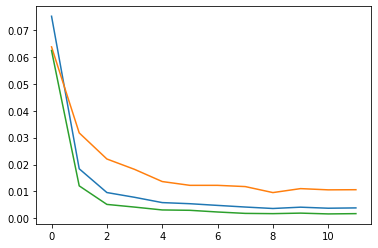

In [33]:
plt.plot(y_grad[:, :3])
#plt.plot(y_001[:, :3])

In [34]:
y_grad

array([[0.07510556, 0.06372635, 0.06236029, 0.01242642, 0.0625    ],
       [0.018409  , 0.03174467, 0.01206007, 0.01427568, 0.11607143],
       [0.00958091, 0.02204937, 0.00517103, 0.01418126, 0.        ],
       [0.00781209, 0.01819531, 0.00417303, 0.0138547 , 0.00892857],
       [0.00584362, 0.01366787, 0.00311005, 0.01452603, 0.        ],
       [0.00542894, 0.01225763, 0.00297741, 0.01473533, 0.        ],
       [0.00480208, 0.01225619, 0.00235084, 0.01527726, 0.        ],
       [0.00419286, 0.01179782, 0.0018333 , 0.01421005, 0.16964285],
       [0.00365229, 0.00956465, 0.00173937, 0.01407216, 0.0625    ],
       [0.00414008, 0.01104041, 0.00193199, 0.01523292, 0.11607143],
       [0.00375234, 0.01058074, 0.00163619, 0.015258  , 0.        ],
       [0.00386917, 0.01063462, 0.00174224, 0.0159249 , 0.05357143]])

Diffeomorphism Failures per batch
tensor(5)


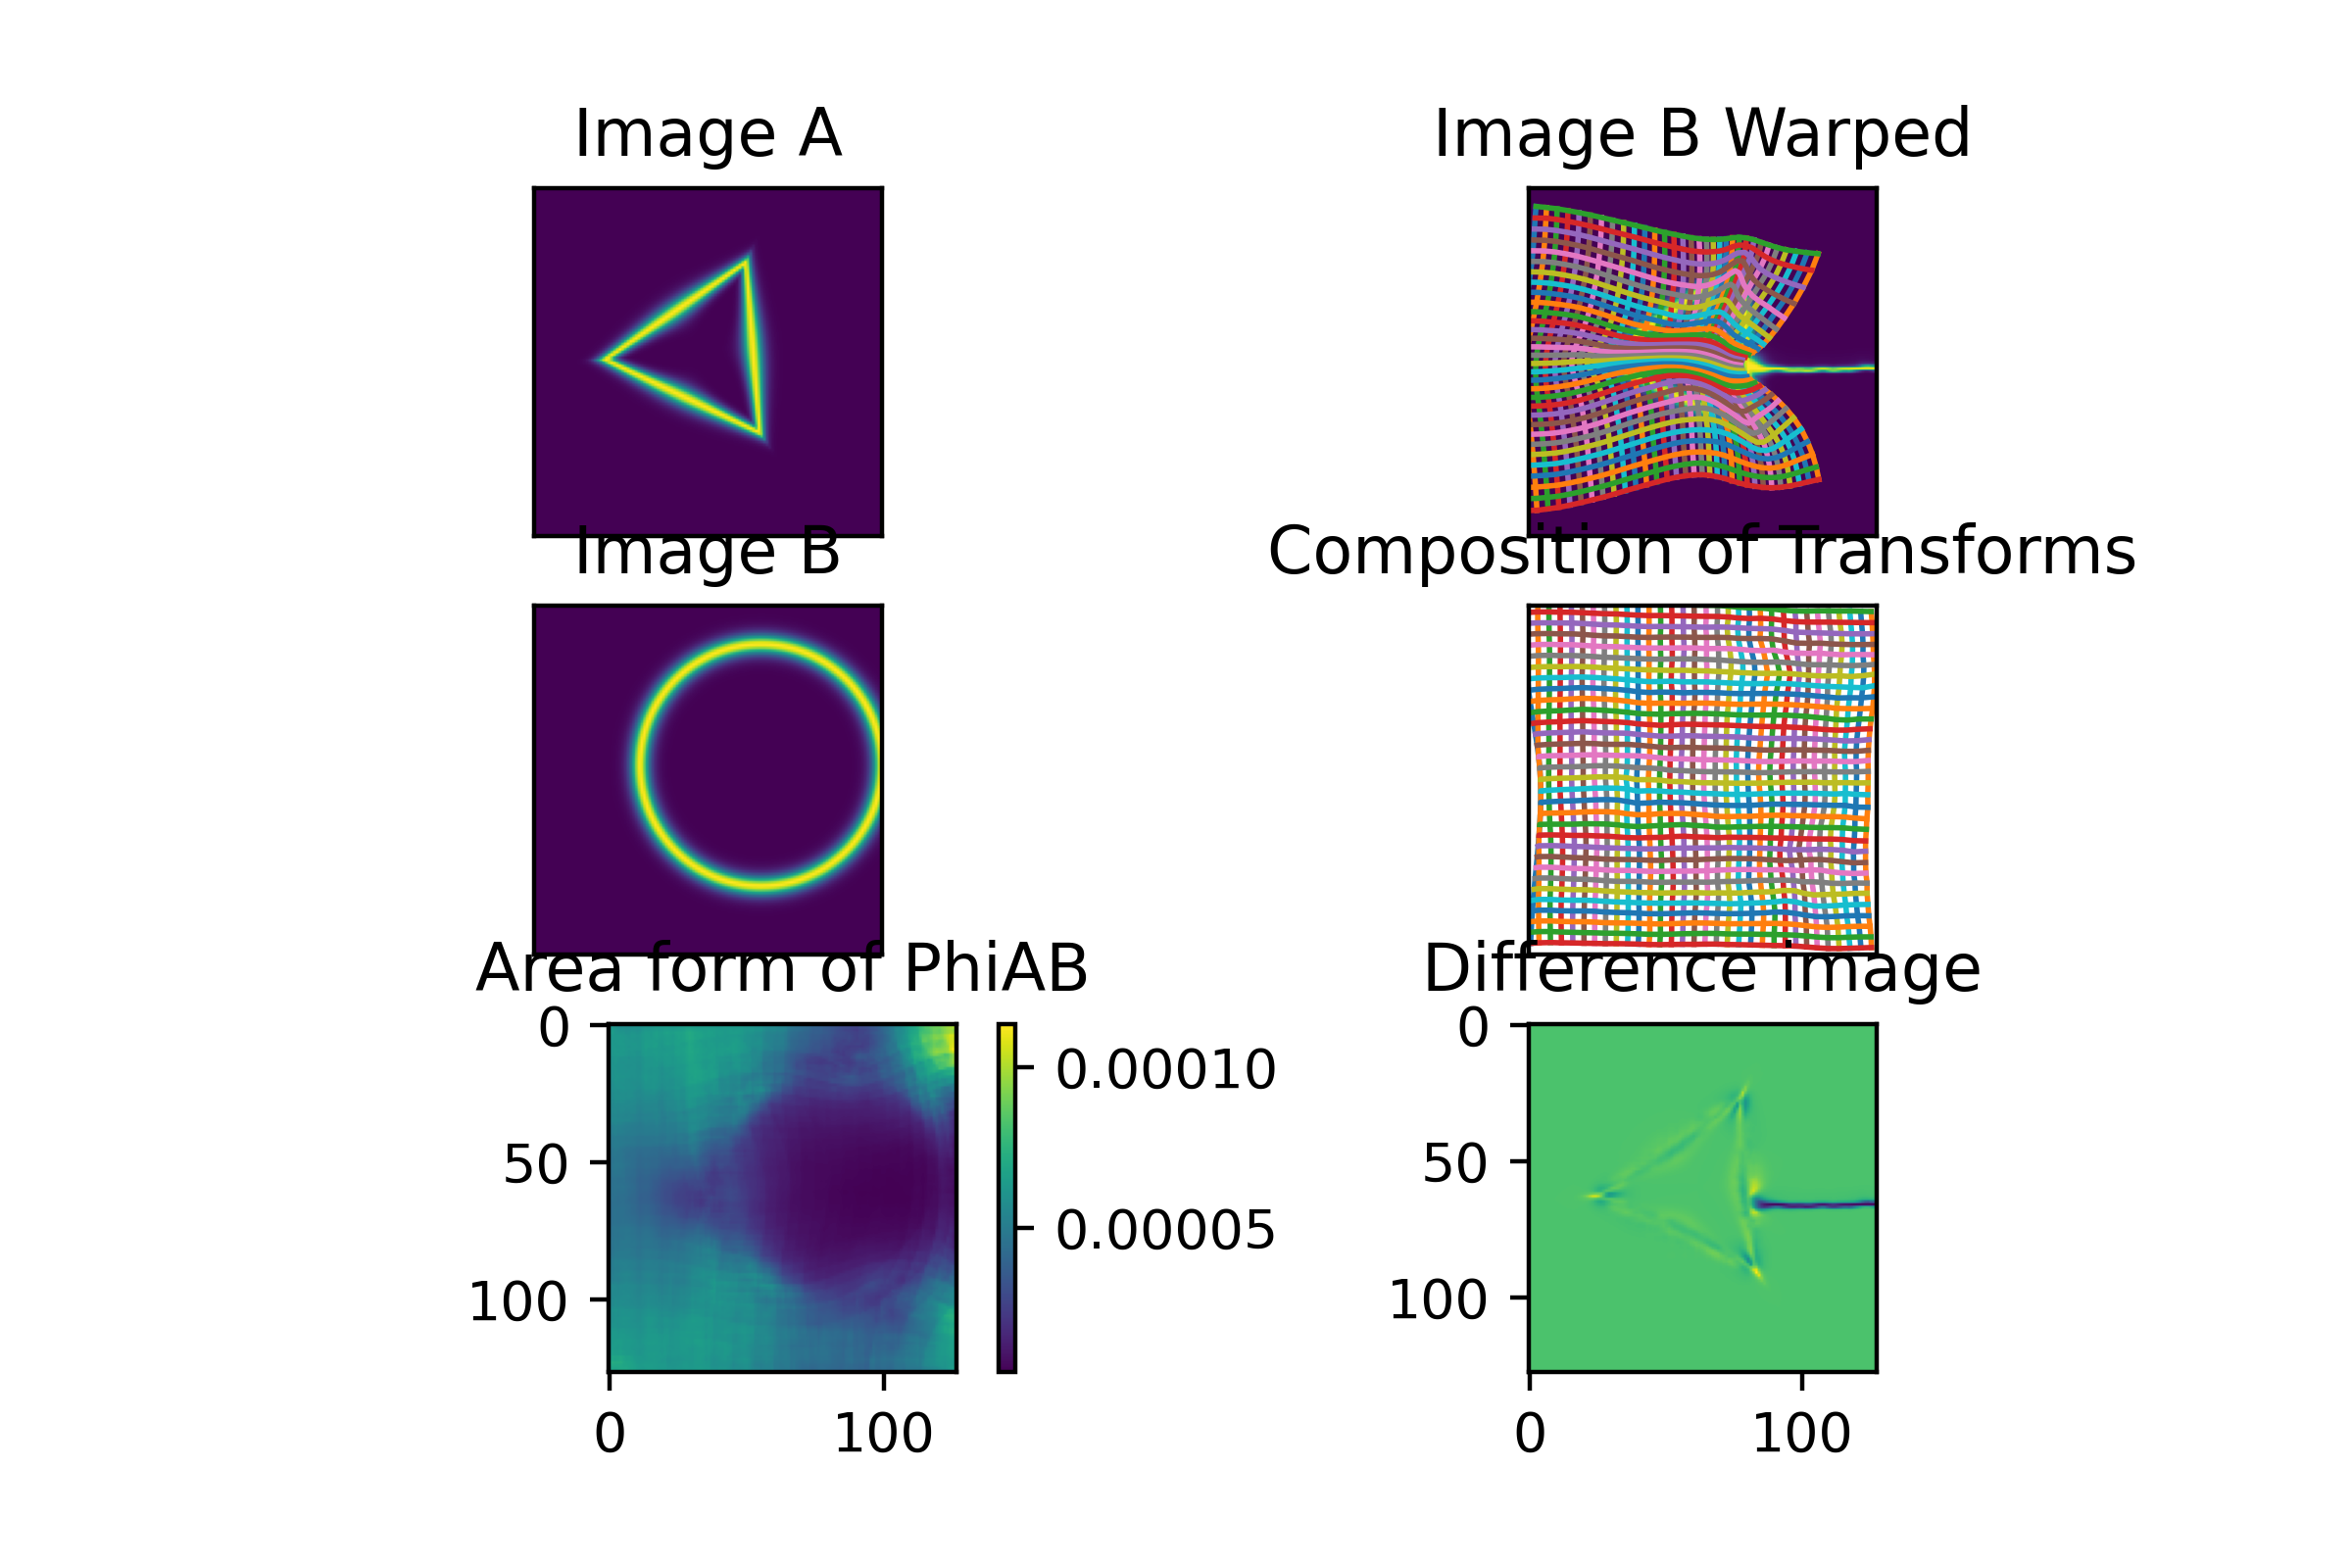

Diffeomorphism Failures per batch
tensor(5)


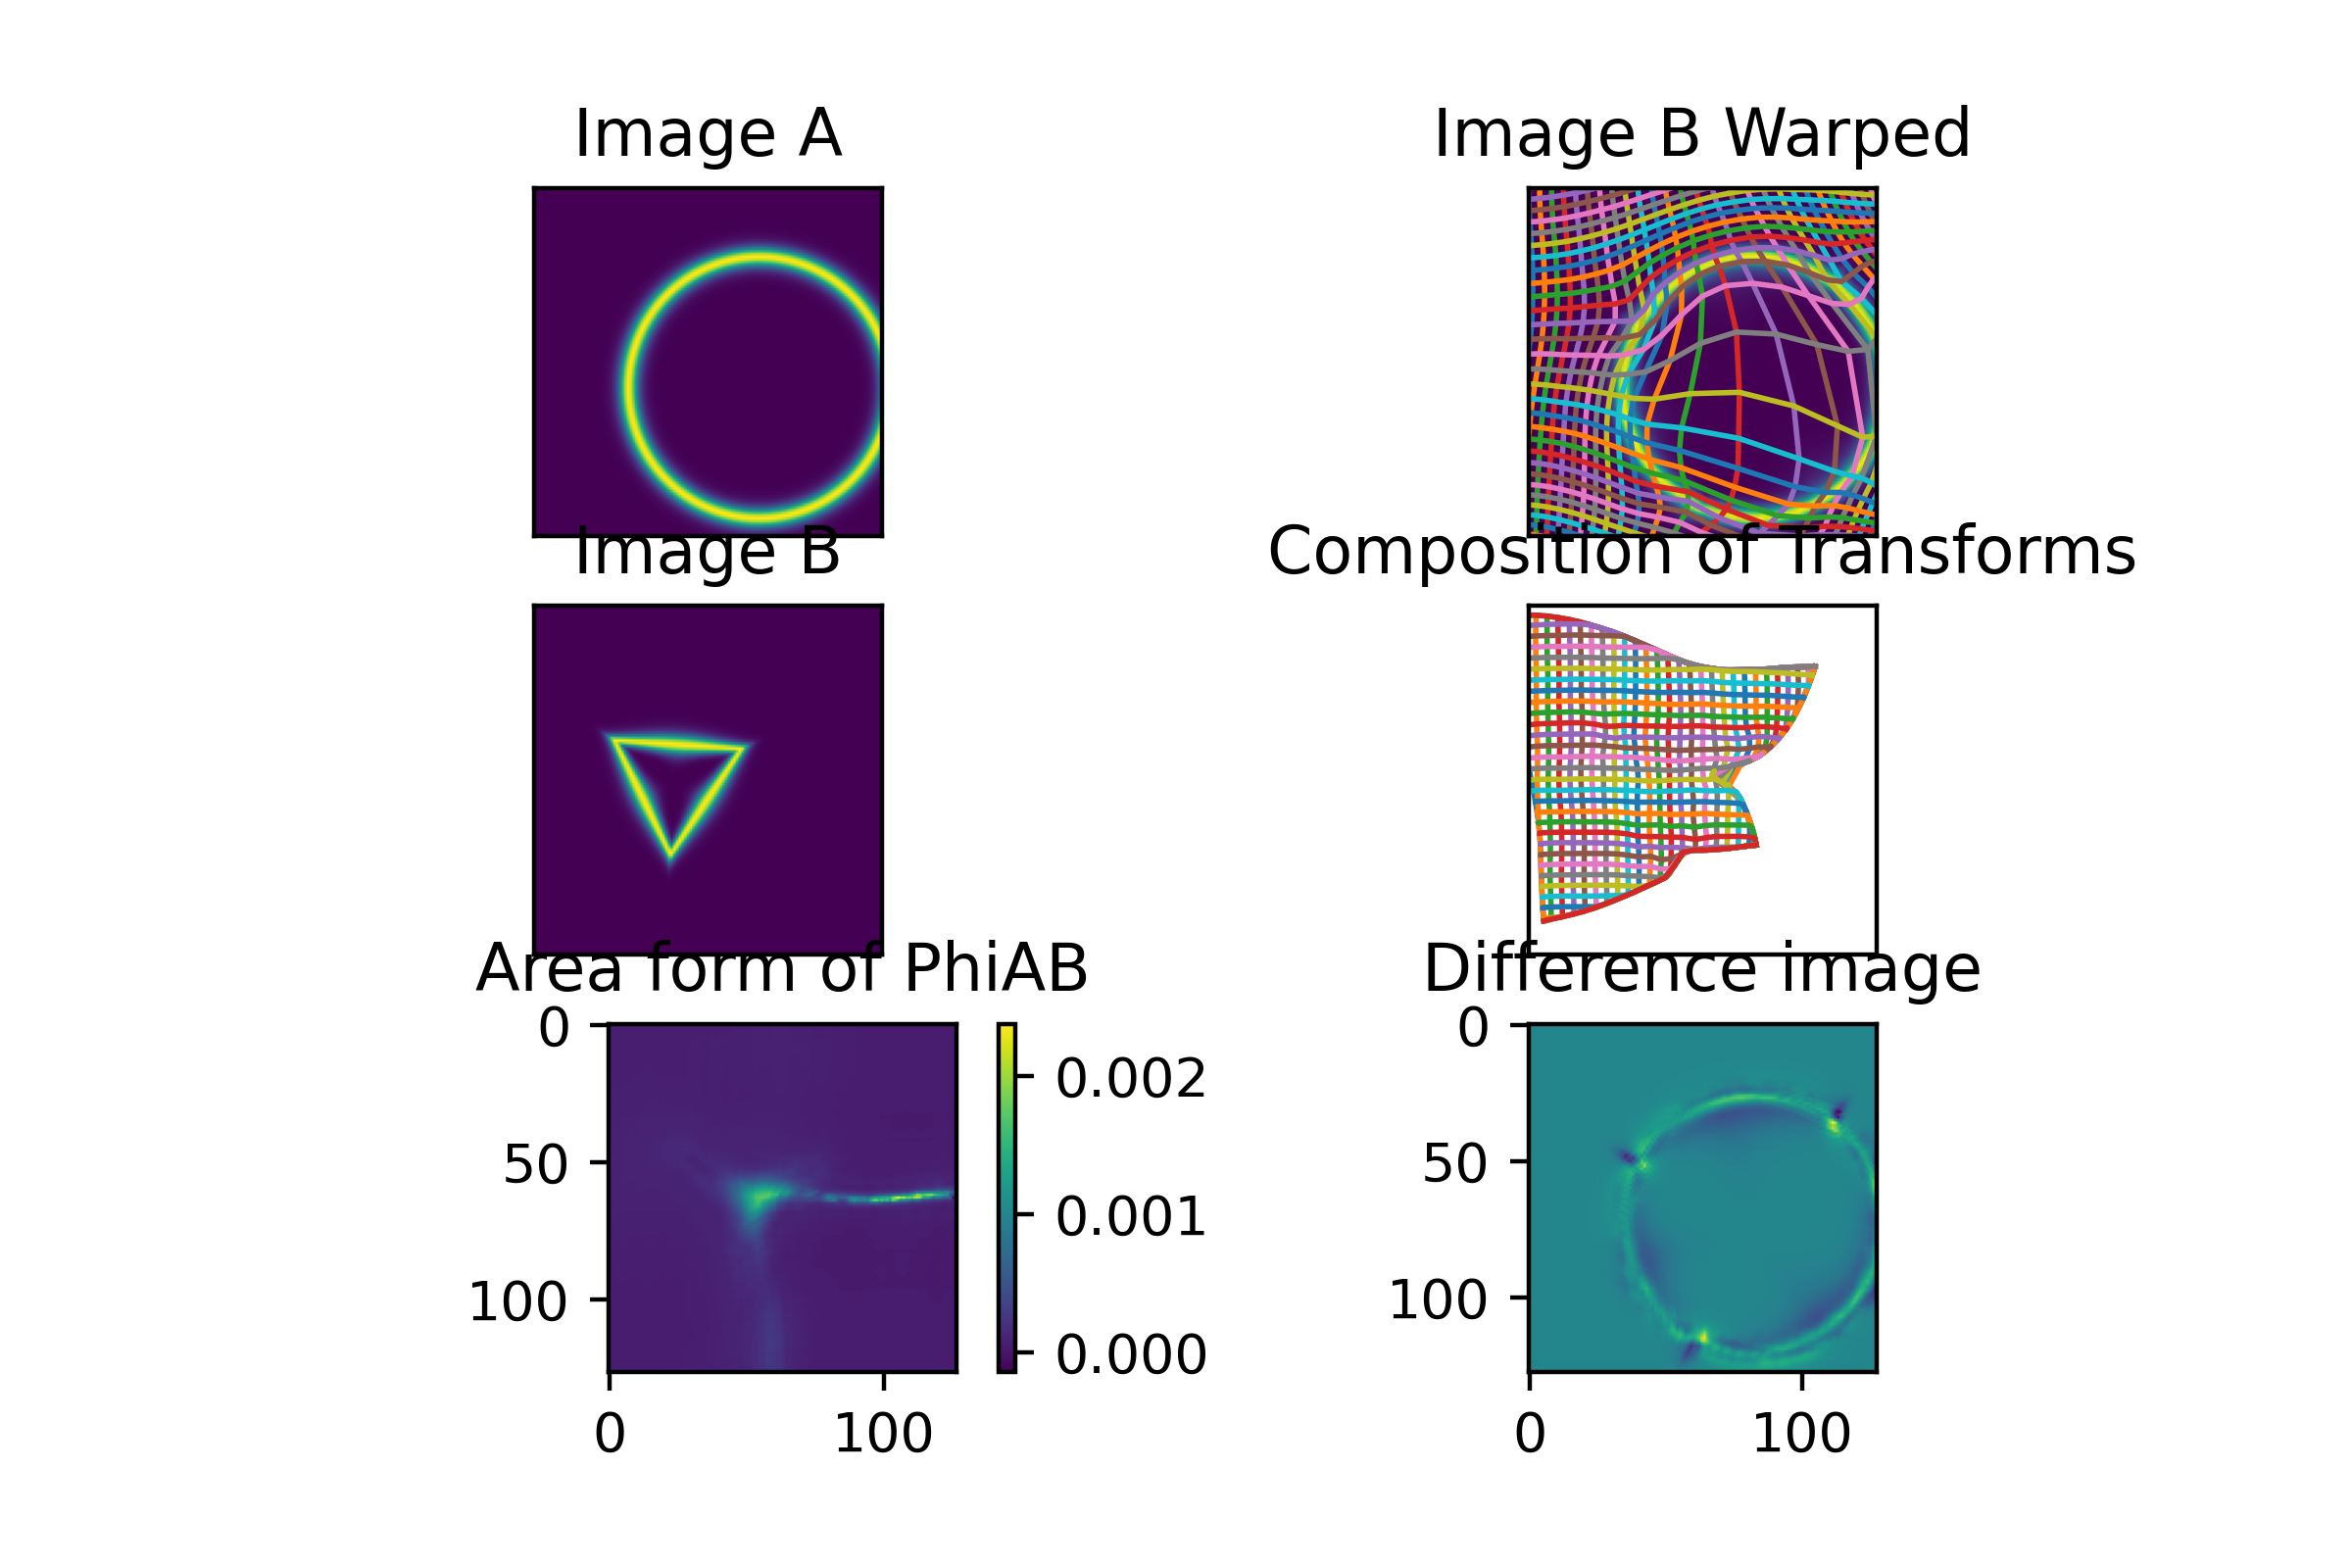

Diffeomorphism Failures per batch
tensor(5)


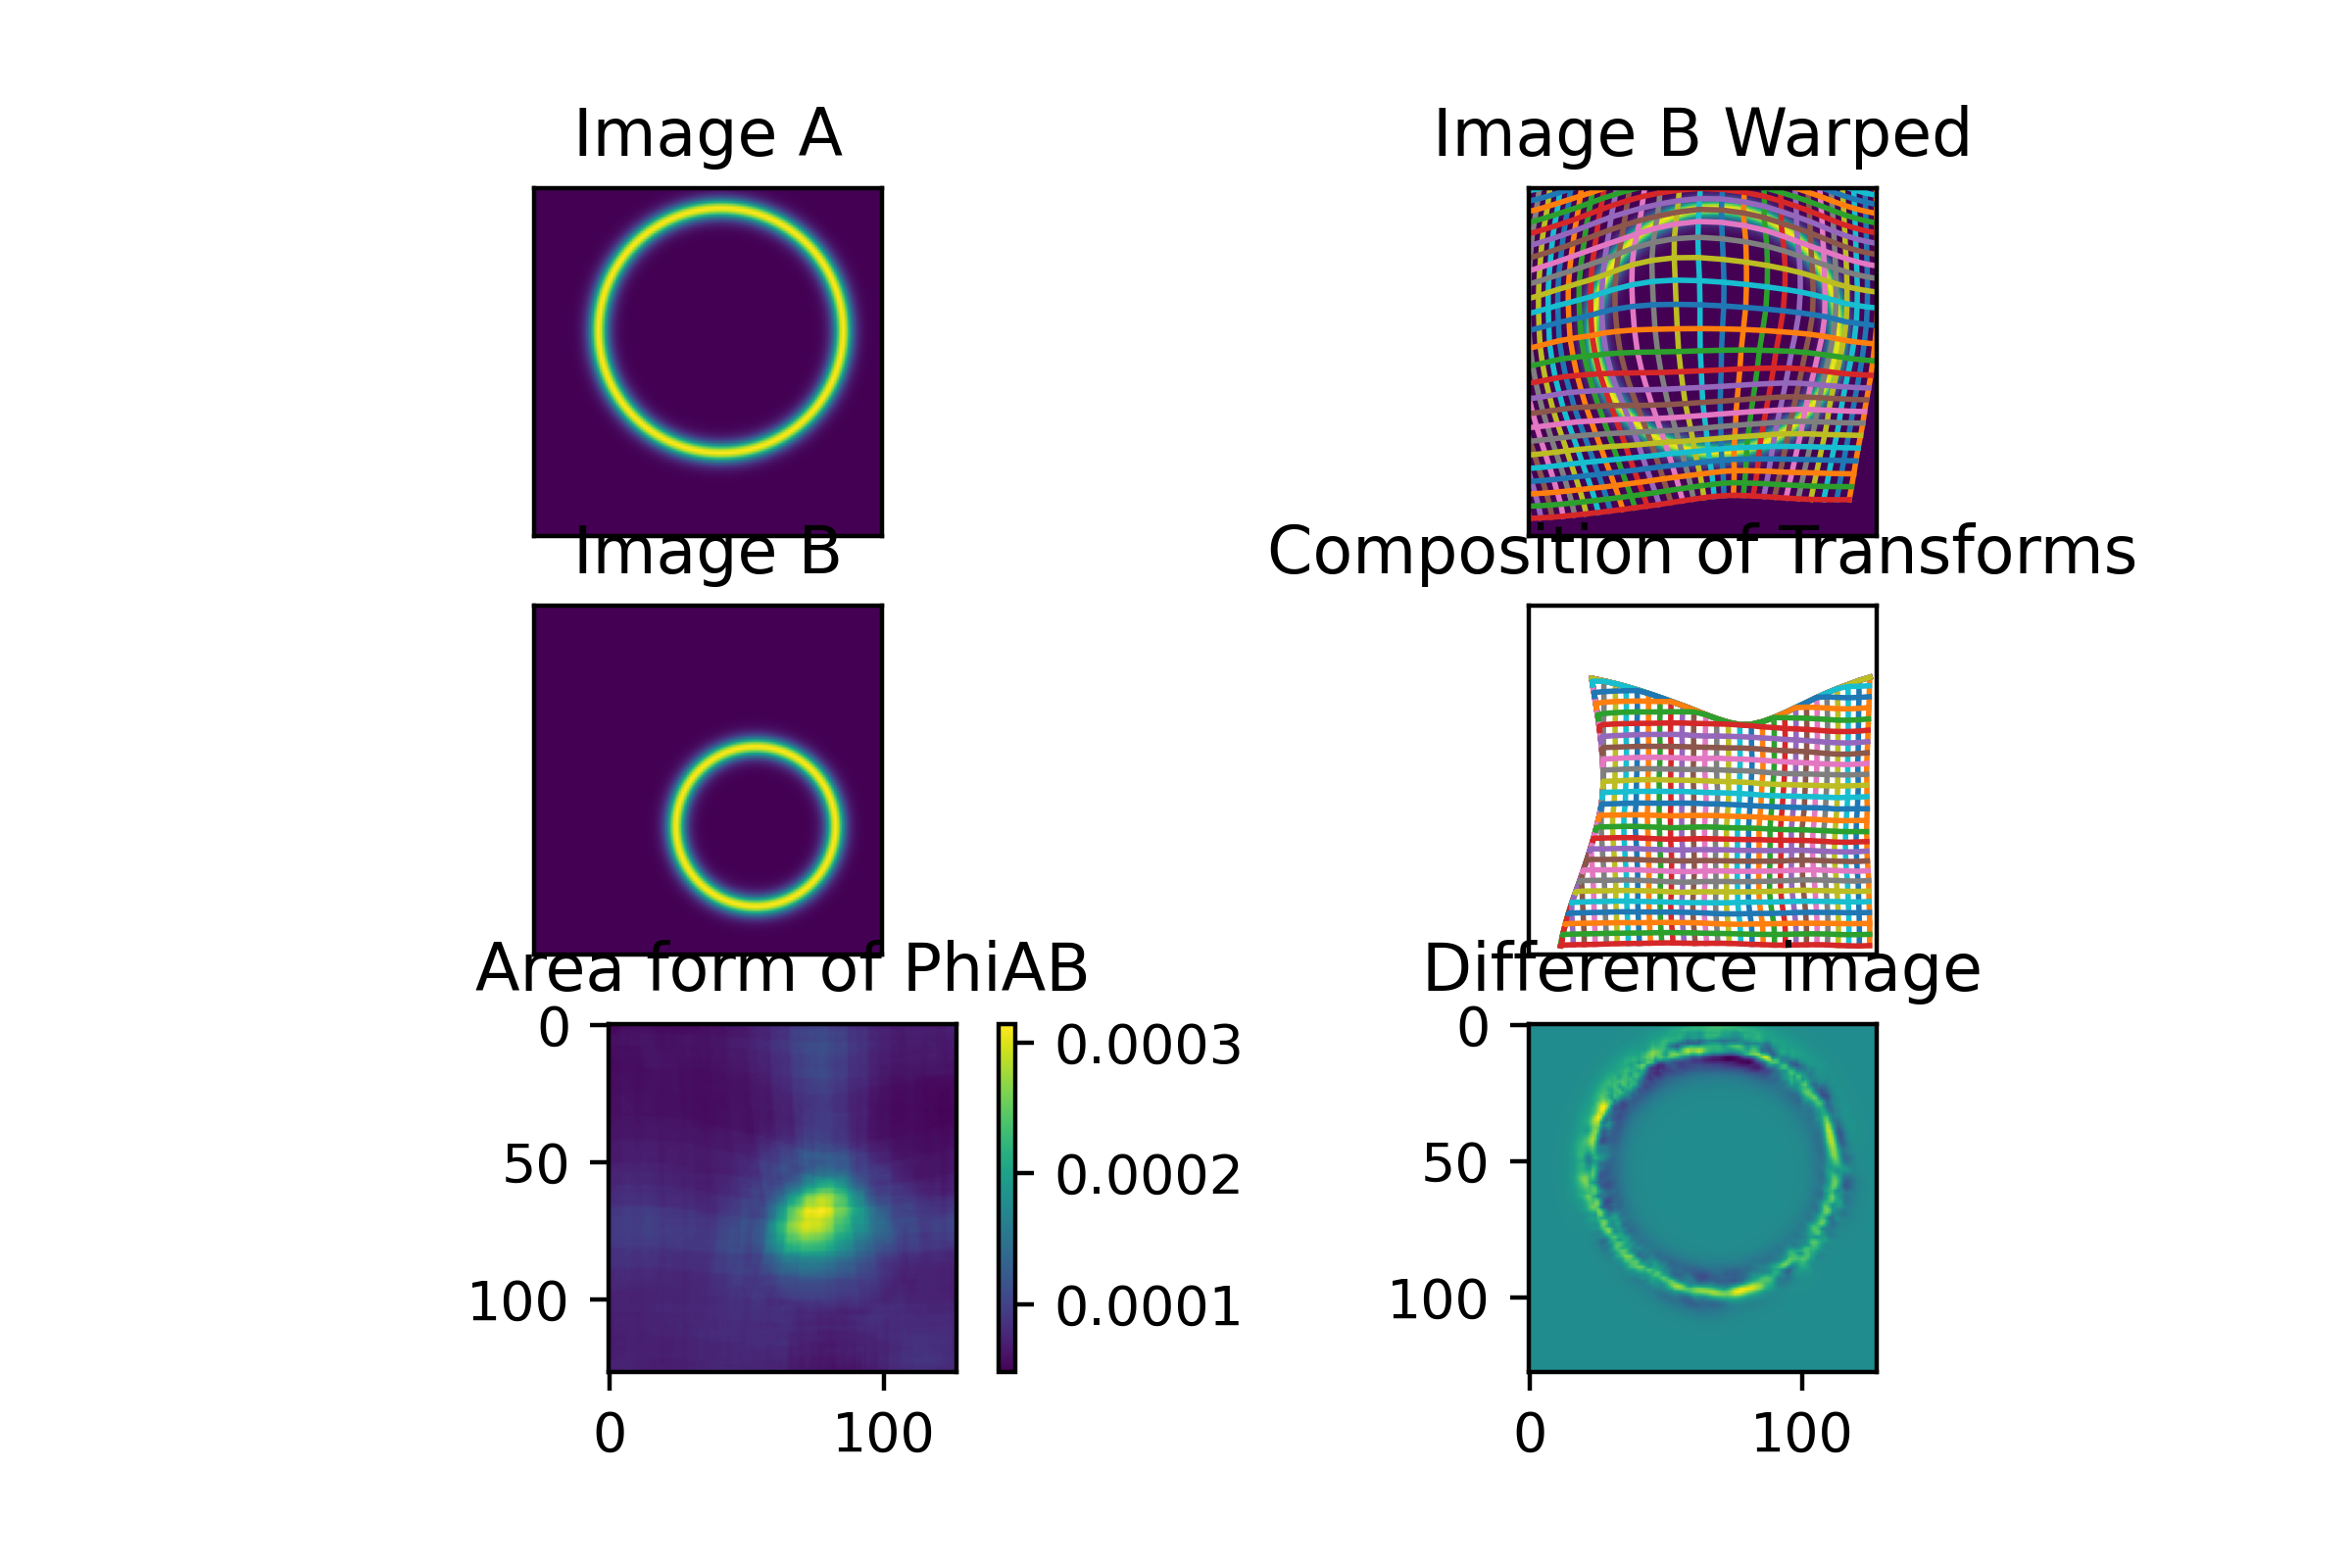

<Figure size 2400x1600 with 0 Axes>

<Figure size 2400x1600 with 0 Axes>

<Figure size 2400x1600 with 0 Axes>

In [35]:
# First registration done all blurry

image_A, image_B = (x[0].cuda() for x in next(zip(d1_t, d2_t)))
with torch.no_grad():
  for N in range(3):
      visualize.visualizeRegistration(
          netGrad,
          image_A,
          image_B,
          N,
          f"test{N}.png"
      )
      display(Image(f"test{N}.png"))


In [36]:
batch = next(iter(d1))[0].cuda()

In [37]:
atlas = torch.nn.Parameter(torch.randn(1, 1, 128, 128, device="cuda"))
#with torch.no_grad():
#  atlas[:] = torch.mean(batch, axis=0, keepdims=True)

atlas_exp = atlas.expand(128, -1, -1, -1).cuda()
params = [atlas]

In [38]:
optim = torch.optim.Adam(params, lr=.3)

In [39]:
for _ in range(730):
  optim.zero_grad()
  loss_obj = netGrad(atlas_exp, batch)
  #(torch.mean((batch - netGrad.warped_image_A)**2))
  loss_obj.all_loss.backward()
  optim.step()
  print(icon.losses.to_floats(loss_obj))

ICONLoss(all_loss=1.70648193359375, inverse_consistency_loss=0.18178045749664307, similarity_loss=1.6701258420944214, transform_magnitude=0.015676572918891907, flips=1.046875)
ICONLoss(all_loss=1.1824898719787598, inverse_consistency_loss=0.12893050909042358, similarity_loss=1.1567037105560303, transform_magnitude=0.013977335765957832, flips=0.5)
ICONLoss(all_loss=0.7872734665870667, inverse_consistency_loss=0.10116496682167053, similarity_loss=0.767040491104126, transform_magnitude=0.01338532380759716, flips=0.171875)
ICONLoss(all_loss=0.5192314386367798, inverse_consistency_loss=0.08315684646368027, similarity_loss=0.5026000738143921, transform_magnitude=0.013058684766292572, flips=0.0234375)
ICONLoss(all_loss=0.35029709339141846, inverse_consistency_loss=0.07136988639831543, similarity_loss=0.33602312207221985, transform_magnitude=0.012832369655370712, flips=0.078125)
ICONLoss(all_loss=0.25351452827453613, inverse_consistency_loss=0.06000940501689911, similarity_loss=0.2415126562118

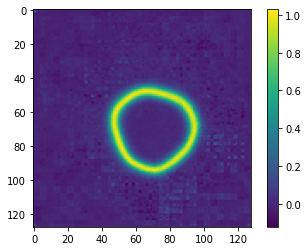

In [40]:
plt.imshow(atlas[0, 0].cpu().detach())
plt.colorbar()

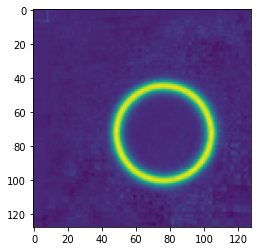

In [41]:
plt.imshow(netGrad.warped_image_A[4, 0].detach().cpu())

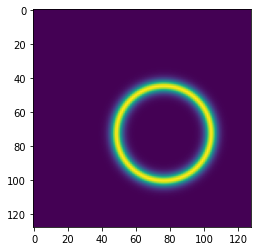

In [42]:
plt.imshow(batch[4, 0].detach().cpu())